Importing libraries


In [1]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")


PyTorch Version: 2.5.1+cu124
CUDA Available: True
CUDA Version: 12.4
Device Name: NVIDIA GeForce GTX 1650


check if cuda is available


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

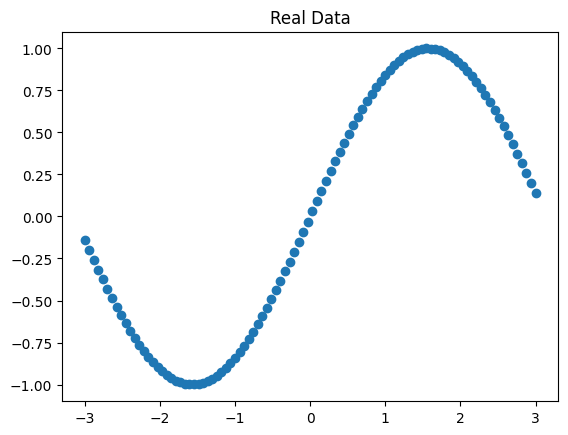

In [15]:
# Create a toy dataset
def generate_real_data(samples=100):
    x = np.linspace(-3, 3, samples)
    y = np.sin(x)
    data = np.stack((x, y), axis=1)
    return torch.tensor(data, dtype=torch.float32, device=device)

# Plot the real data
real_data = generate_real_data()
plt.scatter(real_data[:, 0].cpu(), real_data[:, 1].cpu())
plt.title("Real Data")
plt.show()



## Generator

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),  # First hidden layer (increased neurons)
            nn.ReLU(),
            nn.Linear(32, 64), # Second hidden layer
            nn.ReLU(),
            nn.Linear(64, 32), # Third hidden layer
            nn.ReLU(),
            nn.Linear(32, 2)   # Output layer
        )

    def forward(self, x):
        return self.net(x)

# Initialize generator
generator = Generator().to(device)
print(generator)


Generator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)


## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1), #the 1 in output is the probabilities we are producing
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize discriminator
discriminator = Discriminator().to(device)
print(discriminator)


Discriminator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [ ]:
# Binary Cross-Entropy Loss
criterion = nn.BCELoss()

# Optimizers
lr = 0.002
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)


In [24]:
# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    # Step 1: Train the discriminator
    discriminator_optimizer.zero_grad()

    # Real data
    real_labels = torch.ones(real_data.size(0), 1, device=device)  # Label = 1
    real_output = discriminator(real_data)
    real_loss = criterion(real_output, real_labels)

    # Fake data
    noise = torch.randn(real_data.size(0), 2, device=device)  # Random noise
    fake_data = generator(noise)
    fake_labels = torch.zeros(real_data.size(0), 1, device=device)  # Label = 0
    fake_output = discriminator(fake_data.detach())
    fake_loss = criterion(fake_output, fake_labels)

    # Total discriminator loss
    d_loss = real_loss + fake_loss
    d_loss.backward()
    discriminator_optimizer.step()

    # Step 2: Train the generator
    generator_optimizer.zero_grad()

    # Fake data, but try to fool the discriminator
    fake_output = discriminator(fake_data)
    g_loss = criterion(fake_output, real_labels)  # Labels = 1 to fool D
    g_loss.backward()
    generator_optimizer.step()

    # Print progress
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch 0, D Loss: 1.3757, G Loss: 0.6993
Epoch 500, D Loss: 0.9942, G Loss: 1.8672
Epoch 1000, D Loss: 1.4587, G Loss: 0.6441
Epoch 1500, D Loss: 1.1753, G Loss: 0.9774
Epoch 2000, D Loss: 1.3430, G Loss: 0.7264
Epoch 2500, D Loss: 1.1228, G Loss: 0.8703
Epoch 3000, D Loss: 1.3418, G Loss: 0.7007
Epoch 3500, D Loss: 1.3830, G Loss: 0.7258
Epoch 4000, D Loss: 1.2905, G Loss: 0.7675
Epoch 4500, D Loss: 1.4246, G Loss: 0.7474


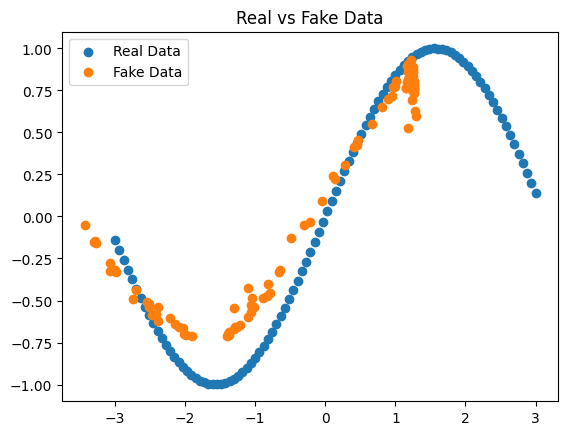

In [25]:
# Generate fake data
noise = torch.randn(100, 2, device=device)
fake_data = generator(noise).cpu().detach().numpy()

# Plot real vs fake data
plt.scatter(real_data[:, 0].cpu(), real_data[:, 1].cpu(), label="Real Data")
plt.scatter(fake_data[:, 0], fake_data[:, 1], label="Fake Data")
plt.legend()
plt.title("Real vs Fake Data")
plt.show()
